# 0- Imports et données

In [ ]:
from transformers import CamembertForSequenceClassification, CamembertTokenizer
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support
from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Internship/lemonde_since1990.csv",
                encoding = "utf-8",
                sep = ";")

In [ ]:
df.to_csv("/content/drive/MyDrive/Internship/lemonde_since1990.csv",
                encoding = "utf-8",
                sep = ";")

In [ ]:
sampled_df.to_csv("sample_LeMonde.csv", encoding = "utf-8", sep = ";")

On crée un échantillon pertinent pour entraîner le modèle :

In [ ]:
keep = ['idees']
international = ['Afrique', 'international' ]
culture = ['m-styles', 'pixels', 'intimites', 'm-le-mag', 'disparitions', "les-recettes-du-monde",
           "m-perso", "mondephilatelique"]

# Utilisation de apply avec une lambda function
df['LABEL'] = df.apply(lambda row: 'culture' if row['Thème'] in culture
                       else 'international' if row['Thème'] in international
                       else 'autre' if row['Thème'] in keep
                       else row['label'] , axis=1)

# 1. Échantillonnage équilibré
def create_balanced_sample(df, class_column, n_per_class):
    # Sélectionner n échantillons de chaque classe
    balanced_sample = df.groupby(class_column).apply(lambda x: x.sample(n=min(n_per_class, len(x)))).reset_index(drop=True)
    return balanced_sample

balanced_df = create_balanced_sample(df, 'LABEL', 3000) #ça ne prend automatiquement pas en compte les na

# Convertir les étiquettes en entiers
label_map = {label: idx for idx, label in enumerate(balanced_df['LABEL'].unique())}
balanced_df['label_id'] = balanced_df['LABEL'].map(label_map)

In [ ]:
label_map

{'autre': 0, 'culture': 1, 'international': 2, 'sport': 3}

Script pour surveiller l'usage des GPU 🇰

In [ ]:
import subprocess
import datetime

def log_gpu_usage():
    try:
        result = subprocess.run(['nvidia-smi'], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        if result.returncode == 0:
            with open('/content/gpu_usage_log.txt', 'a') as f:
                f.write(f"{datetime.datetime.now()}\n")
                f.write(result.stdout.decode('utf-8'))
                f.write("\n\n")
        else:
            print("No GPU found or nvidia-smi command failed.")
    except Exception as e:
        print(f"An error occurred: {e}")

log_gpu_usage()

# I- Classe du modèle et autres

In [ ]:
class CustomLoss(torch.nn.Module):
    def __init__(self, weights):
        super(CustomLoss, self).__init__()
        self.weights = weights

    def forward(self, outputs, labels):
        loss = F.cross_entropy(outputs, labels, reduction='none')
        for i in range(len(labels)):
            if labels[i] == 0:
                loss[i] *= self.weights[0]
        return loss.mean()

class CamembertModel():
    def __init__(self, num_labels, epochs=5, lr=1e-5, batch_size=8, weights=None):
        self.num_labels = num_labels
        self.epochs = epochs
        self.lr = lr
        self.batch_size = batch_size
        self.weights = weights if weights is not None else torch.tensor([1.0] * num_labels)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.tokenizer = CamembertTokenizer.from_pretrained('camembert-base')
        self.model = CamembertForSequenceClassification.from_pretrained('camembert-base', num_labels=num_labels).to(self.device)
        self.model.classifier.dropout = torch.nn.Dropout(0.3)

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr, weight_decay=0.01)
        self.loss_fn = CustomLoss(self.weights)

    def fit(self, X_train, y_train, X_val, y_val):
        inputs_train = self.tokenizer(X_train, padding=True, truncation=True, return_tensors='pt')
        dataset_train = TensorDataset(inputs_train['input_ids'], inputs_train['attention_mask'], torch.tensor(y_train))
        loader_train = DataLoader(dataset_train, batch_size=self.batch_size, shuffle=True)

        inputs_val = self.tokenizer(X_val, padding=True, truncation=True, return_tensors='pt')
        dataset_val = TensorDataset(inputs_val['input_ids'], inputs_val['attention_mask'], torch.tensor(y_val))
        loader_val = DataLoader(dataset_val, batch_size=self.batch_size, shuffle=False)

        best_loss = float('inf')
        patience, trials = 3, 0

        for epoch in range(self.epochs):
            self.model.train()
            total_loss = 0
            progress_bar = tqdm(loader_train, desc=f'Epoch {epoch + 1}/{self.epochs}', leave=False)
            for batch in progress_bar:
                batch = tuple(t.to(self.device) for t in batch)
                inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
                self.optimizer.zero_grad()
                outputs = self.model(**inputs)
                loss = self.loss_fn(outputs.logits, inputs['labels'])
                loss.backward()
                self.optimizer.step()

                total_loss += loss.item()
                progress_bar.set_postfix({'training_loss': '{:.3f}'.format(total_loss / len(progress_bar))})

            val_loss = self.evaluate(loader_val)
            if val_loss < best_loss:
                best_loss = val_loss
                trials = 0
                # Sauvegarder le meilleur modèle
                torch.save(self.model.state_dict(), 'best_model.pt')
            else:
                trials += 1
                if trials >= patience:
                    print(f"Early stopping on epoch {epoch + 1}")
                    break

    def evaluate(self, loader):
        self.model.eval()
        total_loss = 0
        with torch.no_grad():
            for batch in loader:
                batch = tuple(t.to(self.device) for t in batch)
                inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}
                outputs = self.model(**inputs)
                loss = self.loss_fn(outputs.logits, inputs['labels'])
                total_loss += loss.item()
        return total_loss / len(loader)

    def predict(self, X_test):
        self.model.eval()
        inputs = self.tokenizer(X_test, padding=True, truncation=True, return_tensors='pt')
        dataset = TensorDataset(inputs['input_ids'], inputs['attention_mask'])
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)

        all_preds = []
        with torch.no_grad():
            for batch in tqdm(loader, desc='Predicting', leave=False):
                batch = tuple(t.to(self.device) for t in batch)
                inputs = {'input_ids': batch[0], 'attention_mask': batch[1]}
                outputs = self.model(**inputs)
                preds = torch.argmax(outputs.logits, dim=-1)
                all_preds.extend(preds.cpu().numpy())
            self.preds = np.array(all_preds)

    def predict_proba(self, X_test): #Méthode si on veut des probas au lieu de classification directe
        self.model.eval()
        inputs = self.tokenizer(X_test, padding=True, truncation=True, return_tensors='pt')
        dataset = TensorDataset(inputs['input_ids'], inputs['attention_mask'])
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)

        all_probs = []
        with torch.no_grad():
            for batch in tqdm(loader, desc='Predicting', leave=False):
                batch = tuple(t.to(self.device) for t in batch)
                inputs = {'input_ids': batch[0], 'attention_mask': batch[1]}
                outputs = self.model(**inputs)
                probs = torch.softmax(outputs.logits, dim=-1)
                all_probs.extend(probs.cpu().numpy())
        self.probs = np.array(all_probs)
        self.preds_proba = np.argmax(self.probs, axis=1)



    def score(self, y_test):
        accuracy = accuracy_score(y_test, self.preds)
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, self.preds, average='weighted')
        return accuracy, precision, recall, f1

    def confusion_matrix(self, y_test):
        cm = confusion_matrix(y_test, self.preds)
        return cm

    def plot_confusion_matrix(self, cm, labels):
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

# II- Entraînement

In [ ]:
# Définir le modèle
weights = torch.tensor([3.0, 1.0, 1.0, 1.0])
model = CamembertModel(num_labels=4, epochs=5, lr=1e-5, batch_size=8, weights=weights)

## Diviser les données en ensembles d'entraînement et de test
X = balanced_df['Titre'].tolist()
y = balanced_df['label_id'].tolist()

# Diviser les données en ensembles d'entraînement et de test/validation
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Diviser l'ensemble temporaire en ensembles de validation et de test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.fit(X_train, y_train, X_val, y_val )

Early stopping on epoch 5


# III- Evaluation

In [ ]:
model.predict(X_test)

In [ ]:
# Évaluer le modèle
accuracy, precision, recall, f1 = model.score(y_test)
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 0.815
Precision: 0.8238752873741074
Recall: 0.815
F1 Score: 0.8174334905461691


In [ ]:
label_map

{'autre': 0, 'culture': 1, 'international': 2, 'sport': 3}

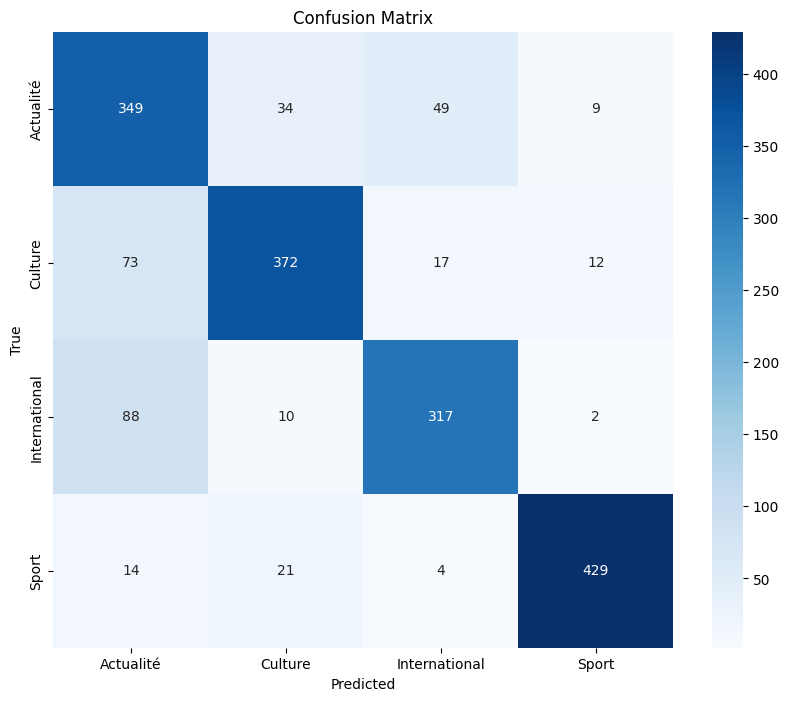

In [ ]:
# Afficher la matrice de confusion
cm = model.confusion_matrix(y_test)
model.plot_confusion_matrix(cm, labels=['Actualité', 'Culture', "International", "Sport"])

In [ ]:
precision, recall, f1, _ = precision_recall_fscore_support(y_test, model.preds, average=None)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: [0.66603053 0.85125858 0.81912145 0.94911504]
Recall: [0.79138322 0.78481013 0.76019185 0.91666667]
F1 Score: [0.72331606 0.81668496 0.78855721 0.9326087 ]


# IV- Utilisation du modèle à grande échelle

In [ ]:
X = balanced_df['Titre'].tolist()
y = balanced_df['label_id'].tolist()

In [ ]:
model.predict(X)

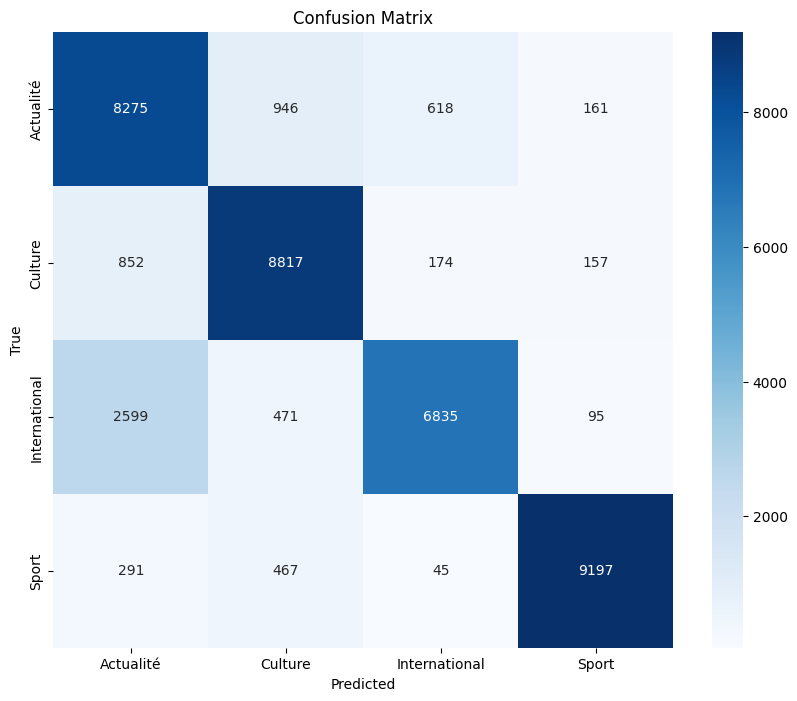

In [ ]:
# Afficher la matrice de confusion
cm = model.confusion_matrix(y)
model.plot_confusion_matrix(cm, labels=['Actualité', 'Culture', "International", "Sport"])

In [ ]:
precision, recall, f1, _ = precision_recall_fscore_support(y, model.preds, average=None)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: [0.68860781 0.82394169 0.89090198 0.95702393]
Recall: [0.8275 0.8817 0.6835 0.9197]
F1 Score: [0.75169187 0.85184291 0.77354006 0.93799082]


In [ ]:
unknown_themes = df[df['LABEL'].isna()]

# Prédire les thèmes pour les lignes avec des thèmes inconnus
# Assumons que `model_final` a une méthode `predict` qui prend une liste de titres (textes) et renvoie une liste de thèmes
model_final.predict(unknown_themes['Titre'].tolist())

# Mettre à jour le DataFrame avec les prédictions
df.loc[df['LABEL'].isna(), 'LABEL'] = model_final.preds

AttributeError: 'numpy.ndarray' object has no attribute 'map'

In [ ]:
import torch

# Enregistrer les paramètres du modèle
torch.save(model_final.model.state_dict(), '/content/drive/MyDrive/Internship/camembert_model.pth')


In [ ]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'links', 'Titre', 'Date', 'Thème',
       'clean_title', 'label', 'label_id', 'theme_pred', 'thème_pred', 'count',
       'mois', 'Sentiment', 'LABEL'],
      dtype='object')

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df= df.sort_values(by='Date')

In [ ]:
label_map

{'autre': 0, 'culture': 1, 'international': 2, 'sport': 3}

In [ ]:
# Inverser le dictionnaire de mappage
inverse_label_map = {v: k for k, v in label_map.items()}

print(inverse_label_map)


{0: 'autre', 1: 'culture', 2: 'international', 3: 'sport'}


In [ ]:
df['Thème_final'] =df["LABEL"].apply(lambda x: inverse_label_map[x] if x in inverse_label_map else x)

In [ ]:
df['Thème_final'].head()

297107          culture
297108          culture
297130    international
297131            autre
297132            autre
Name: Thème_final, dtype: object

In [ ]:
# Échantillon aléatoire des lignes où Thème_final == 'autre'
sampled_df = df[df['Thème_final'] == 'autre'].sample(n=2000, random_state=1)